<a href="https://colab.research.google.com/github/Mamiglia/challenge/blob/master/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flow Matching (FM) — Merge Notebook

**Generated:** 2025-10-31T10:28:17

Questo notebook unisce il contenuto originale di `prova-flow.ipynb` con una
**implementazione completa di Flow Matching (FM)** per il task *translator*
(embedding testuale → embedding immagine).

**Obiettivo:** mantenere *tutto ciò che hai già* (loss ibrida, metriche, funzioni di retrieval)
e aggiungere una pipeline FM che puoi usare in parallelo o in sostituzione del modello attuale.

> Riferimento: *Flow Matching for Generative Modeling* (Lipman et al., 2022).

## 🔧 Quick Start

1. **Assicurati le dipendenze**
   ```bash
   # Se serve (CPU)
   pip install torch numpy scikit-learn matplotlib tqdm
   ```

2. **Dati**
   - Il DataLoader deve restituire batch nella forma `(X_batch, y_batch)`
     dove `X_batch` sono *caption/text embeddings* (dimensione `d_in`)
     e `y_batch` sono *image embeddings* (dimensione `d_out`).

3. **Allenamento FM**
   - Esegui le celle nella sezione *FM: Modello, Loss, Training*.
   - Alla fine ottieni un `vtheta` addestrato e puoi produrre `y_hat`
     integrando l'ODE (pochi step, anche 4–8).

4. **Valutazione**
   - Se nel notebook originale esistono funzioni come `evaluate_retrieval`
     o `generate_submission`, esse verranno riutilizzate.

## 🧠 Cos'è Flow Matching (FM) — in breve

Alleniamo un **campo di velocità** \(v_\theta(z, t \mid x)\) che definisce l'ODE
\(\dot z_t = v_\theta(z_t, t \mid x)\).
Per ogni coppia \((x, y)\) e un \(t \sim \mathcal U[0,1]\), scegliamo una *path*
che collega \(x\) a \(y\) (qui: **lineare**), calcoliamo la **velocità esatta** della path
e facciamo **regressione MSE** del campo a quella velocità (training *simulation-free*).
In *inference*, integriamo l'ODE da \(t{=}0\) a \(1\) per ottenere \(\hat y\).

**Loss FM (path lineare):**
\[
\mathcal L_{\text{FM}} = \mathbb E_{(x,y), t}\,\big\| v_\theta\big((1{-}t)\,x + t\,y,\ t\,\big) - (y{-}x) \big\|_2^2
\]

Per il tuo *translator* questo significa imparare una mappa dinamica
che collega direttamente spazio testo → spazio immagine, integrabile in
**pochi step** con alta qualità.

In [12]:

import math
import numpy as np
from typing import Optional, Callable, Dict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

In [13]:

# === Embedding del tempo (Fourier) e Campo di Velocità condizionato ===

class TimeFourier(nn.Module):
    def __init__(self, n_features: int = 64, learnable: bool = False, scale: float = 2*math.pi):
        super().__init__()
        B = torch.randn(n_features) * scale
        if learnable:
            self.B = nn.Parameter(B)
        else:
            self.register_buffer("B", B, persistent=False)
        self.proj = nn.Linear(2*n_features, 128, bias=False)

    def forward(self, t: torch.Tensor):
        # t: [B, 1]
        wt = t * self.B[None, :]
        feats = torch.cat([torch.cos(wt), torch.sin(wt)], dim=-1)
        return self.proj(feats)


class FlowVectorField(nn.Module):
    """
    v_theta(z, t | x): campo di velocità che muove z lungo t, condizionato da x (caption embedding).
    d_in  = dim(x), d_out = dim(y)  (es. 1024 -> 1536)
    """
    def __init__(self, d_in: int, d_out: int, hidden: int = 1024, t_feats: int = 64):
        super().__init__()
        self.tenc = TimeFourier(t_feats, learnable=False)

        # Proiezioni separate per stabilità
        self.proj_z = nn.Linear(d_out, hidden, bias=False)
        self.proj_x = nn.Linear(d_in,  hidden, bias=False)

        self.net = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden + 128, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden, d_out),
        )

    def forward(self, z_t: torch.Tensor, t: torch.Tensor, x0: torch.Tensor) -> torch.Tensor:
        # z_t: [B, d_out], t: [B,1], x0: [B, d_in]
        te = self.tenc(t)
        h  = self.proj_z(z_t) + self.proj_x(x0)
        h  = torch.cat([h, te], dim=-1)
        return self.net(h)

In [14]:

# === Flow Matching loss (path lineare x->y) ===

def fm_loss(vtheta: FlowVectorField, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    Usa path lineare z_t = (1 - t) * x + t * y, con velocità u_t = y - x.
    Nota: z_t vive nello spazio di y (d_out). Se d_in != d_out, proietta x.
    In questo notebook assumiamo che x e y siano già nella stessa dimensione
    di destinazione (p.es. x mappato a d_out a monte) *oppure* usiamo uno strato
    di allineamento opzionale definito sotto.
    """
    B = x.size(0)
    device = x.device
    t = torch.rand(B, 1, device=device)  # U[0,1]
    z_t = (1.0 - t) * x + t * y          # path in d_out
    u_t = y - x                           # velocità esatta
    v   = vtheta(z_t, t, x0=x)            # campo predetto
    return F.mse_loss(v, u_t)

In [15]:

# === (Opzionale) Proiezione di allineamento d_in -> d_out ===
# Se i tuoi text embeddings hanno d_in != d_out (es. 1024 vs 1536),
# usa questo layer per portare x nello spazio di y PRIMA di FM.

class AlignInToOut(nn.Module):
    def __init__(self, d_in: int, d_out: int, hidden: int = 0):
        super().__init__()
        if hidden > 0:
            self.net = nn.Sequential(
                nn.Linear(d_in, hidden, bias=False),
                nn.SiLU(),
                nn.Linear(hidden, d_out, bias=False),
            )
        else:
            self.net = nn.Linear(d_in, d_out, bias=False)

    def forward(self, x):
        return self.net(x)

In [16]:

# === Integrazione ODE (pochi step) ===

@torch.no_grad()
def integrate_flow(x0: torch.Tensor, vtheta: FlowVectorField, steps: int = 8) -> torch.Tensor:
    """
    Integra l'ODE z' = v_theta(z, t|x0) da t=0 a t=1 con Euler-Midpoint.
    x0 è sia condizione d'ingresso che z iniziale (già in d_out).
    """
    z = x0.clone()
    B = x0.size(0)
    device = x0.device
    for s in range(steps):
        t = torch.full((B, 1), (s + 0.5) / steps, device=device)
        z = z + (1.0 / steps) * vtheta(z, t, x0=x0)
    return z

## ⚙️ FM: Training ibrido (FM + endpoint refinement + regolarizzazioni esistenti)

- **FM loss**: regressione del campo di velocità (simulation-free).
- **Endpoint refinement**: MSE + 1 - Cosine su \(\hat y\) per migliorare il matching finale.
- **Regolarizzazioni opzionali**: se nel notebook originale esistono funzioni
  come `metric_reg`, `align_uniform_loss`, `relational_alignment_loss`, `parallel_transport_loss`,
  verranno chiamate automaticamente se trovate nel `globals()`.

In [17]:

def safe_get_fn(name: str) -> Optional[Callable]:
    fn = globals().get(name, None)
    return fn if callable(fn) else None

def endpoint_refinement(y_hat: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    mse = F.mse_loss(y_hat, y_true)
    cos = 1.0 - F.cosine_similarity(y_hat, y_true, dim=-1).mean()
    return 0.5*mse + 0.5*cos

def train_flow_matching(
    train_loader: DataLoader,
    val_loader: Optional[DataLoader],
    d_in: int,
    d_out: int,
    device: str = "cuda",
    lr: float = 2e-4,
    fm_steps_on_val: int = 8,
    proj_hidden: int = 0,
    hidden: int = 1024,
    t_feats: int = 64,
    epochs: int = 10,
    log_every: int = 50,
):
    # Opzionale proiezione d_in->d_out
    align_in2out = AlignInToOut(d_in, d_out, hidden=proj_hidden).to(device) if d_in != d_out else nn.Identity().to(device)

    vtheta = FlowVectorField(d_in=d_out, d_out=d_out, hidden=hidden, t_feats=t_feats).to(device)
    optim = torch.optim.AdamW(list(vtheta.parameters()) + list(align_in2out.parameters()) if d_in!=d_out else vtheta.parameters(), lr=lr)

    # Regolarizzazioni opzionali
    metric_reg = safe_get_fn('metric_reg')
    align_uniform_loss = safe_get_fn('align_uniform_loss')
    relational_alignment_loss = safe_get_fn('relational_alignment_loss')
    parallel_transport_loss = safe_get_fn('parallel_transport_loss')

    def add_optional_losses(total, y_hat, y_true, extra: Dict):
        # Pesature di default (puoi cambiarle qui)
        if metric_reg:
            total = total + 0.20 * metric_reg(y_hat, y_true)
        if align_uniform_loss:
            total = total + 0.10 * align_uniform_loss(y_hat, y_true)
        if relational_alignment_loss:
            # Se hai una matrice/struttura S_vae o indici, passali via extra
            S_vae = extra.get('S_vae', None)
            idx   = extra.get('idx', None)
            if S_vae is not None and idx is not None:
                total = total + 0.30 * relational_alignment_loss(y_hat, S_vae, idx)
        if parallel_transport_loss:
            X_batch = extra.get('X_batch', None)
            if X_batch is not None:
                total = total + 0.05 * parallel_transport_loss(y_hat, X_batch)
        return total

    def run_epoch(loader, train=True):
        if train: vtheta.train(); align_in2out.train()
        else:     vtheta.eval(); align_in2out.eval()

        running = 0.0
        for i, batch in enumerate(loader, 1):
            if isinstance(batch, (list, tuple)) and len(batch) >= 2:
                X_batch, y_batch = batch[:2]
            else:
                raise ValueError("DataLoader must yield (X_batch, y_batch, ...)")

            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # Porta X nello spazio d_out se serve
            X_proj = align_in2out(X_batch)

            if train:
                optim.zero_grad(set_to_none=True)
                # 1) FM loss sui vettori di velocità
                loss = fm_loss(vtheta, X_proj, y_batch)
                # 2) Endpoint refinement su un forward no-grad
                with torch.no_grad():
                    y_hat = integrate_flow(X_proj, vtheta, steps=4)
                loss = loss + endpoint_refinement(y_hat, y_batch)
                # 3) Reg opzionali
                extra = {'X_batch': X_batch}
                loss = add_optional_losses(loss, y_hat, y_batch, extra)

                loss.backward()
                nn.utils.clip_grad_norm_(vtheta.parameters(), 1.0)
                optim.step()
            else:
                with torch.no_grad():
                    # Valutiamo su endpoint (puoi aggiungere FM loss di validazione se vuoi)
                    y_hat = integrate_flow(X_proj, vtheta, steps=fm_steps_on_val)
                    loss  = endpoint_refinement(y_hat, y_batch)

            running += loss.item()
            if train and (i % log_every == 0):
                print(f"[Train] step {i}/{len(loader)}  loss={running/i:.4f}", end="\r")
        return running / max(1, len(loader))

    best_val = float('inf')
    for ep in range(1, epochs+1):
        tr = run_epoch(train_loader, train=True)
        if val_loader is not None:
            va = run_epoch(val_loader, train=False)
            if va < best_val:
                best_val = va
                torch.save({'vtheta': vtheta.state_dict(),
                            'align_in2out': getattr(align_in2out, 'state_dict', lambda: {})(),
                            'config': {'d_in': d_in, 'd_out': d_out}}, "/mnt/data/fm_best.pt")
                print(f"\n  ✓ Saved best model (val={va:.4f})")
            print(f"Epoch {ep}: train={tr:.4f} | val={va:.4f}")
        else:
            print(f"Epoch {ep}: train={tr:.4f}")

    return vtheta, align_in2out

In [18]:

# === Valutazione (compatibile con funzioni esistenti se presenti) ===

def infer_embeddings(dataloader: DataLoader, vtheta: FlowVectorField, align_in2out: nn.Module, device: str = "cuda", steps: int = 8):
    vtheta.eval(); align_in2out.eval()
    outs = []
    with torch.no_grad():
        for batch in dataloader:
            if isinstance(batch, (list, tuple)) and len(batch) >= 2:
                X_batch, _ = batch[:2]
            else:
                raise ValueError("DataLoader must yield (X_batch, y_batch, ...)")
            X_batch = X_batch.to(device)
            X_proj  = align_in2out(X_batch)
            Y_hat   = integrate_flow(X_proj, vtheta, steps=steps)
            outs.append(Y_hat.cpu())
    return torch.cat(outs, dim=0)

def evaluate_if_available(y_pred, y_true, index=None):
    eval_fn = globals().get('evaluate_retrieval', None)
    if callable(eval_fn):
        return eval_fn(y_pred, y_true, index=index)
    else:
        print("⚠️ 'evaluate_retrieval' non trovato: ritorno None.")
        return None

---

### Note finali
- Se vuoi usare **Rectified Flow** al posto della path lineare, puoi sostituire
  la loss `fm_loss` con una variante di path *rettificata* (spesso consente 1–4 step di integrazione).
- Le pesature delle regolarizzazioni opzionali sono solo un *default*. Tarale con una griglia leggera.
- Per la **submission**, riusa la funzione originale `generate_submission` passando gli embedding `y_hat`.

---

# 📒 Contenuto originale (preservato)

<a href="https://colab.research.google.com/github/Mamiglia/challenge/blob/master/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# !mkdir data
# !gdown 1CVAQDuPOiwm8h9LJ8a_oOs6zOWS6EgkB
# !gdown 1ykZ9fjTxUwdiEwqagoYZiMcD5aG-7rHe
# !unzip -o test.zip -d data
# !unzip -o train.zip -d data

# !git clone https://github.com/Mamiglia/challenge.git

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from tqdm import tqdm
import math
import torch.nn.functional as F 
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from src.common import load_data, prepare_train_data, generate_submission
from src.eval import evaluate_retrieval, visualize_retrieval

In [21]:
# Configuration
MODEL_PATH = "models/mlp_baseline.pth"
EPOCHS = 20
BATCH_SIZE = 128
LR = 1e-4

DEVICE = torch.device("mps" if torch.mps.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


In [22]:
class KernelAdapter(nn.Module):
    """Base kernel adapter with Random Fourier Features"""
    def __init__(self, d_in, d_out, n_feats=256, sigma=0.8, dropout=0.1):
        super().__init__()
        self.W = nn.Parameter(torch.randn(d_in, n_feats) / sigma)
        self.b = nn.Parameter(torch.rand(n_feats) * 2 * math.pi)
        self.fc = nn.Linear(n_feats, d_out)
        self.drop = nn.Dropout(dropout)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, x):
        x_proj = torch.cos(x @ self.W + self.b)
        x_proj = self.drop(x_proj)
        out = self.fc(x_proj)
        return F.normalize(out, dim=-1)


class KernelResidualAdapter(nn.Module):
    """Kernel adapter + residual MLP + local geometric correction"""
    def __init__(self, d_in=1024, d_out=1536, n_feats=512, sigma=0.7):
        super().__init__()
        self.kernel = KernelAdapter(d_in, d_out, n_feats, sigma)
        self.residual = nn.Sequential(
            nn.Linear(d_in, d_out),
            nn.GELU(),
            nn.Linear(d_out, d_out)
        )
        # Local geometric correction (small feature-wise modulation)
        self.local = nn.Sequential(
            nn.Linear(d_in, d_out // 8),
            nn.GELU(),
            nn.Linear(d_out // 8, d_out),
            nn.Tanh()
        )

        # Amplitude scaling gate
        self.scale = nn.Sequential(
            nn.Linear(d_in, d_out),
            nn.Sigmoid()
        )

        # 🔹 Affine alignment layer (Procrustes-like)
        self.align = nn.Linear(d_out, d_out, bias=False)
        nn.init.eye_(self.align.weight)  # inizializza come identità

    def forward(self, x):
        base = self.kernel(x)
        res = self.residual(x)
        local = self.local(x) * 0.3  # local correction term (scaled)
        scale = self.scale(x)

        # composizione finale
        out = (base + 0.5 * res + local) * scale
        out = self.align(out)  # affine rotation layer

        # normalizzazione su sfera unitaria
        # return F.normalize(out, dim=-1)
        return out

In [23]:
def hybrid_loss(z_pred, z_true, temperature=0.15, alpha=0.2, beta=0.6, gamma=1.5, hard_neg_weight=0.1):
    # === Allineamento direzionale ===
    mse = F.mse_loss(z_pred, z_true)
    cos = 1 - F.cosine_similarity(z_pred, z_true, dim=-1).mean()

    # === InfoNCE standard ===
    z_pred = F.normalize(z_pred, dim=-1)
    z_true = F.normalize(z_true, dim=-1)
    logits = (z_pred @ z_true.T) / temperature
    labels = torch.arange(logits.size(0), device=z_pred.device)
    contrast = F.cross_entropy(logits, labels)

    # === Penalizzazione hard negatives (solo nei logits “vicini”) ===
    with torch.no_grad():
        mask_pos = torch.eye(logits.size(0), device=logits.device).bool()
        logits_neg = logits.masked_fill(mask_pos, -1e-9)
        sim_ranks = logits_neg.topk(k=5, dim=1).indices
    hard_mask = torch.zeros_like(logits)
    hard_mask.scatter_(1, sim_ranks, 1.0)
    hard_neg = torch.log1p((hard_mask * torch.exp(logits_neg)).sum(1)).mean()

    return alpha*mse + beta*cos + gamma*contrast + hard_neg_weight * hard_neg

def align_uniform_loss(z1, z2, alpha=2, lam=0.1):
    # Allineamento (positivi)
    align = (z1 - z2).pow(2).sum(1).pow(alpha / 2).mean()

    # Uniformità (negativi)
    z1 = F.normalize(z1, dim=-1)
    sim_matrix = z1 @ z1.T
    sq_dist = 2 - 2 * sim_matrix  # ||x_i - x_j||^2

    # Maschera la diagonale
    n = sq_dist.size(0)
    mask = ~torch.eye(n, device=z1.device, dtype=torch.bool)
    sq_dist_no_diag = sq_dist[mask]

    uniform = torch.log(torch.exp(-lam * sq_dist_no_diag).mean())
    return align + uniform



In [24]:
def metric_reg(z_pred, z_text, k=30):
    with torch.no_grad():
        sims_text = (z_text @ z_text.T)

        # Maschera la diagonale per escludere i self-pairs
        n = sims_text.size(0)
        sims_text = sims_text.masked_fill(torch.eye(n, device=z_text.device).bool(), -1e9)

        # 🔹 Limita k per evitare "selected index out of range"
        k = min(k, n - 1)

        # Trova i top-k simili (escludendo il self)
        idx = sims_text.topk(k, dim=1).indices

        # Crea maschera dei vicini
        mask = torch.zeros_like(sims_text)
        mask.scatter_(1, idx, 1.0)

    sims_pred = (z_pred @ z_pred.T)
    return ((mask * (sims_pred - sims_text))**2).mean()

def relational_alignment_loss(z_pred, S_target, batch_idx):
    """
    Align predicted relational structure (cosine-based) to target geodesic structure.
    Scales cosine [-1,1] → [0,1] to match Gaussian kernel range.
    """
    N = z_pred.shape[0]
    idx_cpu = batch_idx.cpu()
    max_idx = S_target.size(0)

    # Usa solo indici che esistono in S_target
    valid_idx = idx_cpu[idx_cpu < max_idx]
    if len(valid_idx) < 2:
        return torch.tensor(0.0, device=z_pred.device)

    S_sub = S_target[valid_idx][:, valid_idx].to(z_pred.device)

    # Predicted relational structure (cosine-based)
    z_sub = F.normalize(z_pred[:len(valid_idx)], dim=-1)
    S_pred = z_sub @ z_sub.T

    # 🔹 Scale match: map [-1, 1] → [0, 1]
    S_pred = (S_pred + 1) / 2

    # Exclude diagonal
    mask = ~torch.eye(len(valid_idx), device=z_pred.device, dtype=torch.bool)

    loss = F.mse_loss(S_pred[mask], S_sub[mask])
    return loss


In [25]:
def compute_geodesic_similarity(Y, scale=0.5, max_points=2000):
    if len(Y) > max_points:
        idx = torch.randperm(len(Y))[:max_points]
        Y = Y[idx]
    else:
        idx = torch.arange(len(Y))

    dist2 = torch.cdist(Y, Y, p=2).pow(2)
    mean_d2 = dist2.mean().item()
    sigma = (mean_d2 ** 0.5) * scale
    print(f"[auto-sigma] mean distance²={mean_d2:.4f}, sigma={sigma:.4f}")

    S = torch.exp(-dist2 / (2 * sigma**2))
    S = S / S.max()
    return S, idx


In [26]:
def compute_text_similarity(X, max_points=2000):
    if len(X) > max_points:
        idx = torch.randperm(len(X))[:max_points]
        X = X[idx]
    S = (F.cosine_similarity(X.unsqueeze(1), X.unsqueeze(0), dim=-1) + 1) / 2
    return S

In [27]:
def parallel_transport_loss(z_pred, z_text):
    if z_text.size(0) < 2:
        return torch.tensor(0.0, device=z_pred.device)
    dz = z_text[1:] - z_text[:-1]
    dp = z_pred[1:] - z_pred[:-1]
    dz = F.normalize(dz, dim=-1)
    dp = F.normalize(dp, dim=-1)
    # riduci alla dimensione minima comune
    d = min(dz.shape[-1], dp.shape[-1])
    dz, dp = dz[..., :d], dp[..., :d]
    return 1 - F.cosine_similarity(dp, dz, dim=-1).mean()


In [28]:
def train_model(model, train_loader, val_loader, device, epochs, lr, S_vae):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=5e-4,
        epochs=epochs,
        steps_per_epoch=len(train_loader)
    )

    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for X_batch, y_batch, idx_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            outputs = model(X_batch)

            loss = (
                hybrid_loss(outputs, y_batch)
                + 0.2 * metric_reg(outputs, y_batch)
                + 0.1 * align_uniform_loss(outputs, y_batch)
                + 0.3 * relational_alignment_loss(outputs, S_vae, idx_batch)
                + 0.05 * parallel_transport_loss(outputs, X_batch)
            )

            loss.backward()
            optimizer.step()
            scheduler.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # === VALIDATION ===
        model.eval()
        val_loss, cos_sim, mse, contrastive = 0, 0, 0, 0

        with torch.no_grad():
            for X_batch, y_batch, idx_batch in val_loader:  # ✅ aggiornata qui
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = (
                    hybrid_loss(outputs, y_batch)
                    + 0.2 * metric_reg(outputs, y_batch)
                    + 0.1 * align_uniform_loss(outputs, y_batch)
                    + 0.3 * relational_alignment_loss(outputs, S_vae, idx_batch)
                    + 0.05 * parallel_transport_loss(outputs, X_batch)
                )
                val_loss += loss.item()
                cos_sim += F.cosine_similarity(outputs, y_batch, dim=-1).mean().item()
                mse += F.mse_loss(outputs, y_batch).item()
                sim = (F.normalize(outputs, dim=-1) @ F.normalize(y_batch, dim=-1).T)
                pos = torch.arange(sim.size(0), device=device)
                contrastive += F.cross_entropy(sim / 0.07, pos).item()

        n_batches = len(val_loader)
        val_loss /= n_batches
        cos_sim /= n_batches
        mse /= n_batches
        contrastive /= n_batches

        print(f"Cosine={cos_sim:.4f}, MSE={mse:.4f}, Contrastive={contrastive:.4f}")
        print(f"Epoch {epoch+1}: TrainLoss={train_loss:.4f}, ValLoss={val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            Path(MODEL_PATH).parent.mkdir(parents=True, exist_ok=True)
            torch.save(model.state_dict(), MODEL_PATH)
            print(f"  ✓ Saved best model (val_loss={val_loss:.6f})")

    return model


In [29]:
def whiten(X, eps=1e-6):
    X = X - X.mean(0, keepdim=True)
    cov = (X.T @ X) / (X.shape[0] - 1)
    eigvals, eigvecs = torch.linalg.eigh(cov)
    
    # Evita divisione per 0
    eigvals = torch.clamp(eigvals, min=eps)
    
    W = eigvecs @ torch.diag(1.0 / torch.sqrt(eigvals)) @ eigvecs.T
    return X @ W

# SVD VERSION 
# def whiten(X, eps=1e-6):
#     """
#     Whiten data matrix X using SVD decomposition (numerically stable).

#     Args:
#         X (torch.Tensor): input data of shape [N, D]
#         eps (float): small constant for numerical stability
#     Returns:
#         torch.Tensor: whitened data of shape [N, D]
#     """
#     # 1️⃣ Center the data (remove mean)
#     X = X - X.mean(0, keepdim=True)
    
#     # 2️⃣ Compute SVD (does not require explicit covariance)
#     # X = U * S * Vh, where columns of Vh are principal directions
#     U, S, Vh = torch.linalg.svd(X, full_matrices=False)
    
#     # 3️⃣ Scale by inverse sqrt of singular values
#     # (equivalent to dividing by std in each PCA direction)
#     X_white = (U @ torch.diag(1.0 / torch.sqrt(S + eps))) @ Vh
    
#     # 4️⃣ Optional: normalize each vector to unit norm
#     X_white = F.normalize(X_white, dim=-1)
    
#     return X_white

(125000,)
Train data: 125000 captions, 125000 images
[auto-sigma] mean distance²=599.1528, sigma=12.2388
Computed S_vae with shape: torch.Size([2000, 2000])


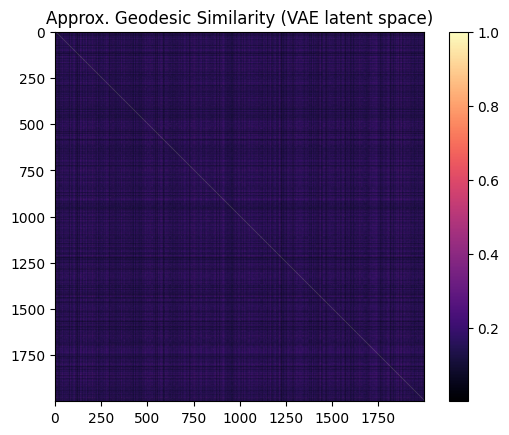

Computed S_text with shape: torch.Size([512, 512])


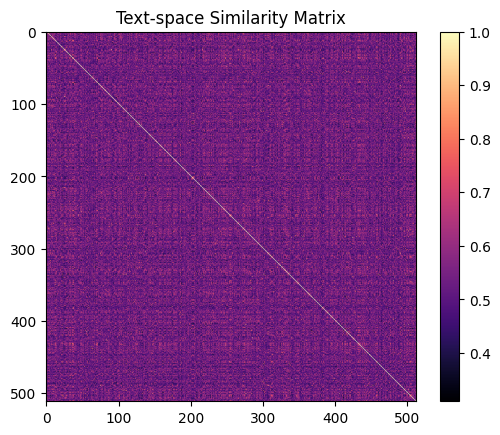

In [31]:
# Load data
train_data = load_data("data/train/train.npz")
X, y, label = prepare_train_data(train_data)

S_vae, idx_vae = compute_geodesic_similarity(y, scale=0.5)
print("Computed S_vae with shape:", S_vae.shape)
plt.imshow(S_vae.cpu().numpy(), cmap='magma')
plt.title("Approx. Geodesic Similarity (VAE latent space)")
plt.colorbar()
plt.show()

# X = whiten(X)
# y = whiten(y)
X = F.normalize(X, dim=-1)
y = F.normalize(y, dim=-1)


# === Approximate Similarity in the Text Embedding Space ===
S_text = compute_text_similarity(X, 512)
print("Computed S_text with shape:", S_text.shape)
plt.imshow(S_text.cpu().numpy(), cmap='magma')
plt.title("Text-space Similarity Matrix")
plt.colorbar()
plt.show()

DATASET_SIZE = len(X)
# Split train/val
# This is done only to measure generalization capabilities, you don't have to
# use a validation set (though we encourage this)
n_train = int(0.9 * len(X))
TRAIN_SPLIT = torch.zeros(len(X), dtype=torch.bool)
TRAIN_SPLIT[:n_train] = 1
X_train, X_val = X[TRAIN_SPLIT], X[~TRAIN_SPLIT]
y_train, y_val = y[TRAIN_SPLIT], y[~TRAIN_SPLIT]


train_dataset = TensorDataset(X_train, y_train, torch.arange(len(X_train)))
val_dataset = TensorDataset(X_val, y_val, torch.arange(len(X_val)))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [32]:
model = KernelResidualAdapter().to(DEVICE)
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Train
print("\n3. Training...")
model = train_model(model, train_loader, val_loader, DEVICE, EPOCHS, LR, S_vae)

# Load best model for evaluation
model.load_state_dict(torch.load(MODEL_PATH))

   Parameters: 9,674,944

3. Training...


Epoch 1/20: 100%|██████████| 879/879 [01:23<00:00, 10.55it/s]


Cosine=0.4504, MSE=0.0006, Contrastive=2.8181
Epoch 1: TrainLoss=6.8035, ValLoss=6.2657
  ✓ Saved best model (val_loss=6.265737)


Epoch 2/20: 100%|██████████| 879/879 [01:22<00:00, 10.67it/s]


Cosine=0.4519, MSE=0.0006, Contrastive=2.5537
Epoch 2: TrainLoss=5.8715, ValLoss=5.9450
  ✓ Saved best model (val_loss=5.944973)


Epoch 3/20: 100%|██████████| 879/879 [01:22<00:00, 10.62it/s]


Cosine=0.4544, MSE=0.0005, Contrastive=2.4763
Epoch 3: TrainLoss=5.6093, ValLoss=5.8513
  ✓ Saved best model (val_loss=5.851272)


Epoch 4/20: 100%|██████████| 879/879 [01:32<00:00,  9.55it/s]


Cosine=0.4646, MSE=0.0006, Contrastive=2.4418
Epoch 4: TrainLoss=5.5030, ValLoss=5.8032
  ✓ Saved best model (val_loss=5.803240)


Epoch 5/20: 100%|██████████| 879/879 [01:20<00:00, 10.93it/s]


Cosine=0.4687, MSE=0.0006, Contrastive=2.4223
Epoch 5: TrainLoss=5.4313, ValLoss=5.7656
  ✓ Saved best model (val_loss=5.765617)


Epoch 6/20: 100%|██████████| 879/879 [01:20<00:00, 10.94it/s]


Cosine=0.4649, MSE=0.0006, Contrastive=2.3933
Epoch 6: TrainLoss=5.3561, ValLoss=5.7236
  ✓ Saved best model (val_loss=5.723602)


Epoch 7/20: 100%|██████████| 879/879 [00:54<00:00, 16.09it/s]


Cosine=0.4631, MSE=0.0006, Contrastive=2.3626
Epoch 7: TrainLoss=5.2754, ValLoss=5.6825
  ✓ Saved best model (val_loss=5.682514)


Epoch 8/20: 100%|██████████| 879/879 [00:40<00:00, 21.69it/s]


Cosine=0.4734, MSE=0.0006, Contrastive=2.3517
Epoch 8: TrainLoss=5.1951, ValLoss=5.6558
  ✓ Saved best model (val_loss=5.655839)


Epoch 9/20: 100%|██████████| 879/879 [00:40<00:00, 21.90it/s]


Cosine=0.4746, MSE=0.0006, Contrastive=2.3341
Epoch 9: TrainLoss=5.1246, ValLoss=5.6317
  ✓ Saved best model (val_loss=5.631696)


Epoch 10/20: 100%|██████████| 879/879 [00:38<00:00, 22.86it/s]


Cosine=0.4674, MSE=0.0006, Contrastive=2.3227
Epoch 10: TrainLoss=5.0600, ValLoss=5.6161
  ✓ Saved best model (val_loss=5.616089)


Epoch 11/20: 100%|██████████| 879/879 [00:40<00:00, 21.84it/s]


Cosine=0.4645, MSE=0.0006, Contrastive=2.3193
Epoch 11: TrainLoss=4.9996, ValLoss=5.6060
  ✓ Saved best model (val_loss=5.606034)


Epoch 12/20: 100%|██████████| 879/879 [00:36<00:00, 23.81it/s]


Cosine=0.4632, MSE=0.0005, Contrastive=2.3090
Epoch 12: TrainLoss=4.9411, ValLoss=5.5950
  ✓ Saved best model (val_loss=5.594973)


Epoch 13/20: 100%|██████████| 879/879 [00:37<00:00, 23.63it/s]


Cosine=0.4599, MSE=0.0005, Contrastive=2.3122
Epoch 13: TrainLoss=4.8856, ValLoss=5.5936
  ✓ Saved best model (val_loss=5.593565)


Epoch 14/20: 100%|██████████| 879/879 [00:37<00:00, 23.72it/s]


Cosine=0.4586, MSE=0.0005, Contrastive=2.3055
Epoch 14: TrainLoss=4.8360, ValLoss=5.5902
  ✓ Saved best model (val_loss=5.590227)


Epoch 15/20: 100%|██████████| 879/879 [00:35<00:00, 24.67it/s]


Cosine=0.4589, MSE=0.0005, Contrastive=2.3080
Epoch 15: TrainLoss=4.7900, ValLoss=5.5934


Epoch 16/20: 100%|██████████| 879/879 [00:37<00:00, 23.75it/s]


Cosine=0.4545, MSE=0.0005, Contrastive=2.3085
Epoch 16: TrainLoss=4.7480, ValLoss=5.5943


Epoch 17/20: 100%|██████████| 879/879 [00:36<00:00, 24.07it/s]


Cosine=0.4521, MSE=0.0005, Contrastive=2.3078
Epoch 17: TrainLoss=4.7133, ValLoss=5.5920


Epoch 18/20: 100%|██████████| 879/879 [00:36<00:00, 24.19it/s]


Cosine=0.4521, MSE=0.0005, Contrastive=2.3082
Epoch 18: TrainLoss=4.6874, ValLoss=5.5954


Epoch 19/20: 100%|██████████| 879/879 [00:35<00:00, 24.42it/s]


Cosine=0.4497, MSE=0.0005, Contrastive=2.3093
Epoch 19: TrainLoss=4.6676, ValLoss=5.5975


Epoch 20/20: 100%|██████████| 879/879 [00:37<00:00, 23.64it/s]


Cosine=0.4499, MSE=0.0005, Contrastive=2.3100
Epoch 20: TrainLoss=4.6594, ValLoss=5.5983


<All keys matched successfully>

## Evaluation

### Visualize

In [33]:
def visualize_latent_space(model, X_val, y_val, device, method="pca", n_samples=2000):
    model.eval()
    with torch.no_grad():
        X_val = X_val[:n_samples].to(device)
        y_val = y_val[:n_samples].to(device)
        z_pred = model(X_val).cpu()
        z_true = y_val.cpu()

    if method == "tsne":
        reducer = TSNE(n_components=2, perplexity=30, n_iter=1000, init="pca")
    else:
        reducer = PCA(n_components=2)

    z_pred_2d = reducer.fit_transform(z_pred)
    z_true_2d = reducer.fit_transform(z_true)

    plt.figure(figsize=(8, 6))
    plt.scatter(z_true_2d[:, 0], z_true_2d[:, 1], alpha=0.5, s=12, label="True (Target Space)")
    plt.scatter(z_pred_2d[:, 0], z_pred_2d[:, 1], alpha=0.5, s=12, label="Predicted (Mapped Space)")
    plt.title(f"Latent Space Visualization ({method.upper()})")
    plt.legend()
    plt.show()


def visualize_tsne(model, X_val, y_val, device, n_samples=2000, perplexity=30, seed=42):
    """
    Visualizza le embedding predette e target nello spazio 2D con t-SNE.
    """
    model.eval()
    with torch.no_grad():
        X_val = X_val[:n_samples].to(device)
        y_val = y_val[:n_samples].to(device)
        z_pred = F.normalize(model(X_val), dim=-1).cpu().numpy()
        z_true = F.normalize(y_val, dim=-1).cpu().numpy()

    # Concatena per ottenere embedding congiunte
    Z = np.concatenate([z_pred, z_true], axis=0)
    labels = np.array([0] * len(z_pred) + [1] * len(z_true))  # 0=pred, 1=true

    # Riduzione con t-SNE
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        n_iter=1000,
        init="pca",
        learning_rate="auto",
        random_state=seed,
        verbose=1
    )
    Z_2d = tsne.fit_transform(Z)

    # Split per colore
    Z_pred_2d = Z_2d[labels == 0]
    Z_true_2d = Z_2d[labels == 1]

    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(Z_true_2d[:, 0], Z_true_2d[:, 1],
                alpha=0.45, s=18, c="#1f77b4", label="True (target space)")
    plt.scatter(Z_pred_2d[:, 0], Z_pred_2d[:, 1],
                alpha=0.45, s=18, c="#ff7f0e", label="Predicted (mapped space)")
    plt.title(f"t-SNE of Predicted vs True Embeddings ({n_samples} samples)")
    plt.legend()
    plt.tight_layout()
    plt.show()



In [35]:
import plotly.graph_objects as go
from sklearn.decomposition import PCA
import torch
import numpy as np
import torch.nn.functional as F

def visualize_latent_space_3d(model, X_val, y_val, device, n_samples=2000, method="pca"):
    """
    Visualizza gli embedding predetti e target in 3D (interattivo) con Plotly.
    """
    model.eval()
    with torch.no_grad():
        X_val = X_val[:n_samples].to(device)
        y_val = y_val[:n_samples].to(device)
        z_pred = F.normalize(model(X_val), dim=-1).cpu().numpy()
        z_true = F.normalize(y_val, dim=-1).cpu().numpy()

    # Riduzione dimensionale (3D)
    if method == "tsne":
        from sklearn.manifold import TSNE
        reducer = TSNE(n_components=3, perplexity=30, n_iter=1000, init="pca", learning_rate="auto")
        Z_pred = reducer.fit_transform(z_pred)
        Z_true = reducer.fit_transform(z_true)
    else:
        reducer = PCA(n_components=3)
        Z_pred = reducer.fit_transform(z_pred)
        Z_true = reducer.fit_transform(z_true)

    # Creazione grafico interattivo
    fig = go.Figure()

    # Target space
    fig.add_trace(go.Scatter3d(
        x=Z_true[:,0], y=Z_true[:,1], z=Z_true[:,2],
        mode='markers',
        marker=dict(size=3, color='royalblue', opacity=0.6),
        name='True (Target Space)'
    ))

    # Predicted space
    fig.add_trace(go.Scatter3d(
        x=Z_pred[:,0], y=Z_pred[:,1], z=Z_pred[:,2],
        mode='markers',
        marker=dict(size=3, color='orange', opacity=0.6),
        name='Predicted (Mapped Space)'
    ))

    fig.update_layout(
        title=f"3D Latent Space Visualization ({method.upper()})",
        scene=dict(
            xaxis_title='Component 1',
            yaxis_title='Component 2',
            zaxis_title='Component 3'
        ),
        width=850,
        height=700,
        legend=dict(x=0.02, y=0.98)
    )

    fig.show()


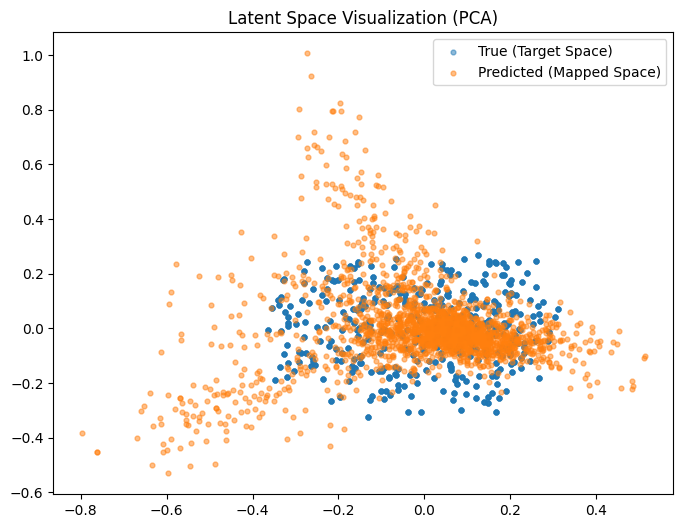

TypeError: TSNE.__init__() got an unexpected keyword argument 'n_iter'

In [36]:
from challenge.src.eval import visualize_retrieval
import numpy as np
import torch

visualize_latent_space(model, X_val, y_val, DEVICE, method="pca")
visualize_tsne(model, X_val, y_val, DEVICE, n_samples=2000)


visualize_latent_space_3d(model, X_val, y_val, DEVICE, n_samples=2000, method="pca")
visualize_latent_space_3d(model, X_val, y_val, DEVICE, n_samples=1000, method="tsne")

val_caption_text = train_data['captions/text'][~TRAIN_SPLIT]
val_text_embd = X_val
img_VAL_SPLIT = label[~TRAIN_SPLIT].sum(dim=0) > 0
val_img_file = train_data['images/names'][img_VAL_SPLIT]
val_img_embd = torch.from_numpy(train_data['images/embeddings'][img_VAL_SPLIT])
val_label = np.nonzero(train_data['captions/label'][~TRAIN_SPLIT][:,img_VAL_SPLIT])[1]

# Sample and visualize
for i in range(5):
    idx = np.random.randint(0, 100)
    caption_embd = val_text_embd[idx]
    caption_text = val_caption_text[idx]
    gt_index = val_label[idx]

    with torch.no_grad():
        pred_embds = model(caption_embd.to(DEVICE)).cpu()

        visualize_retrieval(
            pred_embds,
            gt_index,
            val_img_file,
            caption_text, val_img_embd, k=5)

## Submission

In [ ]:
test_data = load_data("data/test/test.clean.npz")

test_embds = test_data['captions/embeddings']
test_embds = torch.from_numpy(test_embds).float()

with torch.no_grad():
    pred_embds = model(test_embds.to(DEVICE)).cpu()

submission = generate_submission(test_data['captions/ids'], pred_embds, 'submission.csv')
print(f"Model saved to: {MODEL_PATH}")

Generating submission file...
✓ Saved submission to submission.csv
Model saved to: models/mlp_baseline.pth


In [ ]:
# --- Evaluate retrieval performance ---
from challenge.src.eval import evaluate_retrieval  # adattalo al tuo path
import numpy as np

model.eval()
with torch.no_grad():
    z_pred_val = model(X_val.to(DEVICE)).cpu()

# ground truth embeddings (target images)
z_img_val = y_val.cpu()
gt_indices = np.arange(len(z_img_val))  # ogni caption ha la sua immagine target

results = evaluate_retrieval(
    translated_embd=z_pred_val,
    image_embd=z_img_val,
    gt_indices=gt_indices,
    max_indices=50,
    batch_size=128
)

print("\n=== Retrieval evaluation (validation set) ===")
for k, v in results.items():
    print(f"{k:>12}: {v:.4f}")



=== Retrieval evaluation (validation set) ===
         mrr: 0.4030
        ndcg: 0.5430
 recall_at_1: 0.1720
 recall_at_3: 0.5063
 recall_at_5: 0.8386
recall_at_10: 0.9386
recall_at_50: 0.9959
     l2_dist: 0.9009


In [ ]:
# !mkdir data
# !gdown 1CVAQDuPOiwm8h9LJ8a_oOs6zOWS6EgkB
# !gdown 1ykZ9fjTxUwdiEwqagoYZiMcD5aG-7rHe
# !unzip -o test.zip -d data
# !unzip -o train.zip -d data

# !git clone https://github.com/Mamiglia/challenge.git

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from tqdm import tqdm
import math
import torch.nn.functional as F 
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from src.common import load_data, prepare_train_data, generate_submission

In [ ]:
# Configuration
MODEL_PATH = "models/mlp_baseline.pth"
EPOCHS = 20
BATCH_SIZE = 128
LR = 1e-4

DEVICE = torch.device("mps" if torch.mps.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: mps


In [ ]:
class KernelAdapter(nn.Module):
    """Base kernel adapter with Random Fourier Features"""
    def __init__(self, d_in, d_out, n_feats=256, sigma=0.8, dropout=0.1):
        super().__init__()
        self.W = nn.Parameter(torch.randn(d_in, n_feats) / sigma)
        self.b = nn.Parameter(torch.rand(n_feats) * 2 * math.pi)
        self.fc = nn.Linear(n_feats, d_out)
        self.drop = nn.Dropout(dropout)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, x):
        x_proj = torch.cos(x @ self.W + self.b)
        x_proj = self.drop(x_proj)
        out = self.fc(x_proj)
        return F.normalize(out, dim=-1)


class KernelResidualAdapter(nn.Module):
    """Kernel adapter + residual MLP + local geometric correction"""
    def __init__(self, d_in=1024, d_out=1536, n_feats=512, sigma=0.7):
        super().__init__()
        self.kernel = KernelAdapter(d_in, d_out, n_feats, sigma)
        self.residual = nn.Sequential(
            nn.Linear(d_in, d_out),
            nn.GELU(),
            nn.Linear(d_out, d_out)
        )
        # Local geometric correction (small feature-wise modulation)
        self.local = nn.Sequential(
            nn.Linear(d_in, d_out // 8),
            nn.GELU(),
            nn.Linear(d_out // 8, d_out),
            nn.Tanh()
        )

        # Amplitude scaling gate
        self.scale = nn.Sequential(
            nn.Linear(d_in, d_out),
            nn.Sigmoid()
        )

        # 🔹 Affine alignment layer (Procrustes-like)
        self.align = nn.Linear(d_out, d_out, bias=False)
        nn.init.eye_(self.align.weight)  # inizializza come identità

    def forward(self, x):
        base = self.kernel(x)
        res = self.residual(x)
        local = self.local(x) * 0.3  # local correction term (scaled)
        scale = self.scale(x)

        # composizione finale
        out = (base + 0.5 * res + local) * scale
        out = self.align(out)  # affine rotation layer

        # normalizzazione su sfera unitaria
        # return F.normalize(out, dim=-1)
        return out

In [ ]:
def hybrid_loss(z_pred, z_true, temperature=0.15, alpha=0.2, beta=0.6, gamma=1.5, hard_neg_weight=0.1):
    # === Allineamento direzionale ===
    mse = F.mse_loss(z_pred, z_true)
    cos = 1 - F.cosine_similarity(z_pred, z_true, dim=-1).mean()

    # === InfoNCE standard ===
    z_pred = F.normalize(z_pred, dim=-1)
    z_true = F.normalize(z_true, dim=-1)
    logits = (z_pred @ z_true.T) / temperature
    labels = torch.arange(logits.size(0), device=z_pred.device)
    contrast = F.cross_entropy(logits, labels)

    # === Penalizzazione hard negatives (solo nei logits “vicini”) ===
    with torch.no_grad():
        mask_pos = torch.eye(logits.size(0), device=logits.device).bool()
        logits_neg = logits.masked_fill(mask_pos, -1e-9)
        sim_ranks = logits_neg.topk(k=5, dim=1).indices
    hard_mask = torch.zeros_like(logits)
    hard_mask.scatter_(1, sim_ranks, 1.0)
    hard_neg = torch.log1p((hard_mask * torch.exp(logits_neg)).sum(1)).mean()

    return alpha*mse + beta*cos + gamma*contrast + hard_neg_weight * hard_neg

def align_uniform_loss(z1, z2, alpha=2, lam=0.1):
    # Allineamento (positivi)
    align = (z1 - z2).pow(2).sum(1).pow(alpha / 2).mean()

    # Uniformità (negativi)
    z1 = F.normalize(z1, dim=-1)
    sim_matrix = z1 @ z1.T
    sq_dist = 2 - 2 * sim_matrix  # ||x_i - x_j||^2

    # Maschera la diagonale
    n = sq_dist.size(0)
    mask = ~torch.eye(n, device=z1.device, dtype=torch.bool)
    sq_dist_no_diag = sq_dist[mask]

    uniform = torch.log(torch.exp(-lam * sq_dist_no_diag).mean())
    return align + uniform



In [ ]:
def metric_reg(z_pred, z_text, k=30):
    with torch.no_grad():
        sims_text = (z_text @ z_text.T)

        # Maschera la diagonale per escludere i self-pairs
        n = sims_text.size(0)
        sims_text = sims_text.masked_fill(torch.eye(n, device=z_text.device).bool(), -1e9)

        # 🔹 Limita k per evitare "selected index out of range"
        k = min(k, n - 1)

        # Trova i top-k simili (escludendo il self)
        idx = sims_text.topk(k, dim=1).indices

        # Crea maschera dei vicini
        mask = torch.zeros_like(sims_text)
        mask.scatter_(1, idx, 1.0)

    sims_pred = (z_pred @ z_pred.T)
    return ((mask * (sims_pred - sims_text))**2).mean()

def relational_alignment_loss(z_pred, S_target, batch_idx):
    """
    Align predicted relational structure (cosine-based) to target geodesic structure.
    Scales cosine [-1,1] → [0,1] to match Gaussian kernel range.
    """
    N = z_pred.shape[0]
    idx_cpu = batch_idx.cpu()
    max_idx = S_target.size(0)

    # Usa solo indici che esistono in S_target
    valid_idx = idx_cpu[idx_cpu < max_idx]
    if len(valid_idx) < 2:
        return torch.tensor(0.0, device=z_pred.device)

    S_sub = S_target[valid_idx][:, valid_idx].to(z_pred.device)

    # Predicted relational structure (cosine-based)
    z_sub = F.normalize(z_pred[:len(valid_idx)], dim=-1)
    S_pred = z_sub @ z_sub.T

    # 🔹 Scale match: map [-1, 1] → [0, 1]
    S_pred = (S_pred + 1) / 2

    # Exclude diagonal
    mask = ~torch.eye(len(valid_idx), device=z_pred.device, dtype=torch.bool)

    loss = F.mse_loss(S_pred[mask], S_sub[mask])
    return loss


In [ ]:
def compute_geodesic_similarity(Y, scale=0.5, max_points=2000):
    if len(Y) > max_points:
        idx = torch.randperm(len(Y))[:max_points]
        Y = Y[idx]
    else:
        idx = torch.arange(len(Y))

    dist2 = torch.cdist(Y, Y, p=2).pow(2)
    mean_d2 = dist2.mean().item()
    sigma = (mean_d2 ** 0.5) * scale
    print(f"[auto-sigma] mean distance²={mean_d2:.4f}, sigma={sigma:.4f}")

    S = torch.exp(-dist2 / (2 * sigma**2))
    S = S / S.max()
    return S, idx


In [ ]:
def compute_text_similarity(X, max_points=2000):
    if len(X) > max_points:
        idx = torch.randperm(len(X))[:max_points]
        X = X[idx]
    S = (F.cosine_similarity(X.unsqueeze(1), X.unsqueeze(0), dim=-1) + 1) / 2
    return S

In [ ]:
def parallel_transport_loss(z_pred, z_text):
    if z_text.size(0) < 2:
        return torch.tensor(0.0, device=z_pred.device)
    dz = z_text[1:] - z_text[:-1]
    dp = z_pred[1:] - z_pred[:-1]
    dz = F.normalize(dz, dim=-1)
    dp = F.normalize(dp, dim=-1)
    # riduci alla dimensione minima comune
    d = min(dz.shape[-1], dp.shape[-1])
    dz, dp = dz[..., :d], dp[..., :d]
    return 1 - F.cosine_similarity(dp, dz, dim=-1).mean()


In [ ]:
def train_model(model, train_loader, val_loader, device, epochs, lr, S_vae):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=5e-4,
        epochs=epochs,
        steps_per_epoch=len(train_loader)
    )

    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for X_batch, y_batch, idx_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            outputs = model(X_batch)

            loss = (
                hybrid_loss(outputs, y_batch)
                + 0.2 * metric_reg(outputs, y_batch)
                + 0.1 * align_uniform_loss(outputs, y_batch)
                + 0.3 * relational_alignment_loss(outputs, S_vae, idx_batch)
                + 0.05 * parallel_transport_loss(outputs, X_batch)
            )

            loss.backward()
            optimizer.step()
            scheduler.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # === VALIDATION ===
        model.eval()
        val_loss, cos_sim, mse, contrastive = 0, 0, 0, 0

        with torch.no_grad():
            for X_batch, y_batch, idx_batch in val_loader:  # ✅ aggiornata qui
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = (
                    hybrid_loss(outputs, y_batch)
                    + 0.2 * metric_reg(outputs, y_batch)
                    + 0.1 * align_uniform_loss(outputs, y_batch)
                    + 0.3 * relational_alignment_loss(outputs, S_vae, idx_batch)
                    + 0.05 * parallel_transport_loss(outputs, X_batch)
                )
                val_loss += loss.item()
                cos_sim += F.cosine_similarity(outputs, y_batch, dim=-1).mean().item()
                mse += F.mse_loss(outputs, y_batch).item()
                sim = (F.normalize(outputs, dim=-1) @ F.normalize(y_batch, dim=-1).T)
                pos = torch.arange(sim.size(0), device=device)
                contrastive += F.cross_entropy(sim / 0.07, pos).item()

        n_batches = len(val_loader)
        val_loss /= n_batches
        cos_sim /= n_batches
        mse /= n_batches
        contrastive /= n_batches

        print(f"Cosine={cos_sim:.4f}, MSE={mse:.4f}, Contrastive={contrastive:.4f}")
        print(f"Epoch {epoch+1}: TrainLoss={train_loss:.4f}, ValLoss={val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            Path(MODEL_PATH).parent.mkdir(parents=True, exist_ok=True)
            torch.save(model.state_dict(), MODEL_PATH)
            print(f"  ✓ Saved best model (val_loss={val_loss:.6f})")

    return model


In [ ]:
def whiten(X, eps=1e-6):
    X = X - X.mean(0, keepdim=True)
    cov = (X.T @ X) / (X.shape[0] - 1)
    eigvals, eigvecs = torch.linalg.eigh(cov)
    
    # Evita divisione per 0
    eigvals = torch.clamp(eigvals, min=eps)
    
    W = eigvecs @ torch.diag(1.0 / torch.sqrt(eigvals)) @ eigvecs.T
    return X @ W

# SVD VERSION 
# def whiten(X, eps=1e-6):
#     """
#     Whiten data matrix X using SVD decomposition (numerically stable).

#     Args:
#         X (torch.Tensor): input data of shape [N, D]
#         eps (float): small constant for numerical stability
#     Returns:
#         torch.Tensor: whitened data of shape [N, D]
#     """
#     # 1️⃣ Center the data (remove mean)
#     X = X - X.mean(0, keepdim=True)
    
#     # 2️⃣ Compute SVD (does not require explicit covariance)
#     # X = U * S * Vh, where columns of Vh are principal directions
#     U, S, Vh = torch.linalg.svd(X, full_matrices=False)
    
#     # 3️⃣ Scale by inverse sqrt of singular values
#     # (equivalent to dividing by std in each PCA direction)
#     X_white = (U @ torch.diag(1.0 / torch.sqrt(S + eps))) @ Vh
    
#     # 4️⃣ Optional: normalize each vector to unit norm
#     X_white = F.normalize(X_white, dim=-1)
    
#     return X_white

(125000,)
Train data: 125000 captions, 125000 images
[auto-sigma] mean distance²=588.3429, sigma=12.1279
Computed S_vae with shape: torch.Size([2000, 2000])


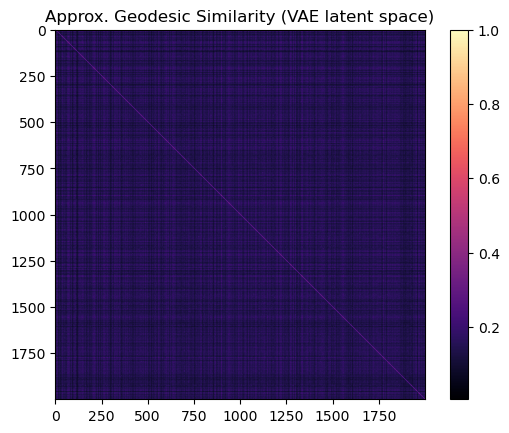

Computed S_text with shape: torch.Size([512, 512])


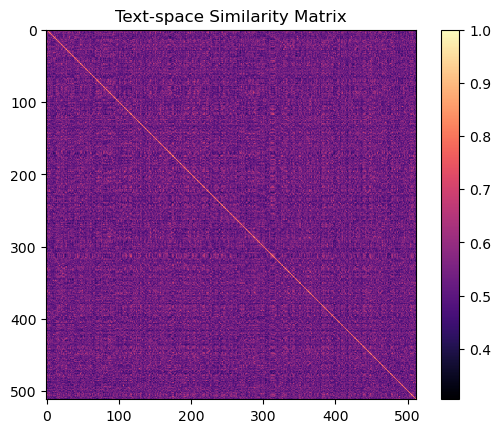

In [ ]:
# Load data
train_data = load_data("data/train/train.npz")
X, y, label = prepare_train_data(train_data)

S_vae, idx_vae = compute_geodesic_similarity(y, scale=0.5)
print("Computed S_vae with shape:", S_vae.shape)
plt.imshow(S_vae.cpu().numpy(), cmap='magma')
plt.title("Approx. Geodesic Similarity (VAE latent space)")
plt.colorbar()
plt.show()

# X = whiten(X)
# y = whiten(y)
X = F.normalize(X, dim=-1)
y = F.normalize(y, dim=-1)


# === Approximate Similarity in the Text Embedding Space ===
S_text = compute_text_similarity(X, 512)
print("Computed S_text with shape:", S_text.shape)
plt.imshow(S_text.cpu().numpy(), cmap='magma')
plt.title("Text-space Similarity Matrix")
plt.colorbar()
plt.show()

DATASET_SIZE = len(X)
# Split train/val
# This is done only to measure generalization capabilities, you don't have to
# use a validation set (though we encourage this)
n_train = int(0.9 * len(X))
TRAIN_SPLIT = torch.zeros(len(X), dtype=torch.bool)
TRAIN_SPLIT[:n_train] = 1
X_train, X_val = X[TRAIN_SPLIT], X[~TRAIN_SPLIT]
y_train, y_val = y[TRAIN_SPLIT], y[~TRAIN_SPLIT]


train_dataset = TensorDataset(X_train, y_train, torch.arange(len(X_train)))
val_dataset = TensorDataset(X_val, y_val, torch.arange(len(X_val)))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [ ]:
model = KernelResidualAdapter().to(DEVICE)
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Train
print("\n3. Training...")
model = train_model(model, train_loader, val_loader, DEVICE, EPOCHS, LR, S_vae)

# Load best model for evaluation
model.load_state_dict(torch.load(MODEL_PATH))

   Parameters: 9,674,944

3. Training...


Epoch 1/20: 100%|██████████| 879/879 [00:39<00:00, 22.43it/s]


Cosine=0.4490, MSE=0.0006, Contrastive=2.8189
Epoch 1: TrainLoss=6.8039, ValLoss=6.2626
  ✓ Saved best model (val_loss=6.262648)


Epoch 2/20: 100%|██████████| 879/879 [00:39<00:00, 22.44it/s]


Cosine=0.4542, MSE=0.0005, Contrastive=2.5495
Epoch 2: TrainLoss=5.8714, ValLoss=5.9419
  ✓ Saved best model (val_loss=5.941882)


Epoch 3/20: 100%|██████████| 879/879 [00:39<00:00, 22.30it/s]


Cosine=0.4580, MSE=0.0005, Contrastive=2.4780
Epoch 3: TrainLoss=5.6120, ValLoss=5.8477
  ✓ Saved best model (val_loss=5.847687)


Epoch 4/20: 100%|██████████| 879/879 [00:41<00:00, 21.25it/s]


Cosine=0.4660, MSE=0.0005, Contrastive=2.4450
Epoch 4: TrainLoss=5.5034, ValLoss=5.8068
  ✓ Saved best model (val_loss=5.806776)


Epoch 5/20: 100%|██████████| 879/879 [00:40<00:00, 21.66it/s]


Cosine=0.4621, MSE=0.0006, Contrastive=2.4131
Epoch 5: TrainLoss=5.4331, ValLoss=5.7652
  ✓ Saved best model (val_loss=5.765163)


Epoch 6/20: 100%|██████████| 879/879 [00:40<00:00, 21.80it/s]


Cosine=0.4614, MSE=0.0006, Contrastive=2.3948
Epoch 6: TrainLoss=5.3553, ValLoss=5.7230
  ✓ Saved best model (val_loss=5.722964)


Epoch 7/20: 100%|██████████| 879/879 [00:40<00:00, 21.94it/s]


Cosine=0.4668, MSE=0.0006, Contrastive=2.3711
Epoch 7: TrainLoss=5.2726, ValLoss=5.6858
  ✓ Saved best model (val_loss=5.685838)


Epoch 8/20: 100%|██████████| 879/879 [00:38<00:00, 22.68it/s]


Cosine=0.4699, MSE=0.0006, Contrastive=2.3521
Epoch 8: TrainLoss=5.1957, ValLoss=5.6540
  ✓ Saved best model (val_loss=5.653992)


Epoch 9/20: 100%|██████████| 879/879 [00:39<00:00, 22.42it/s]


Cosine=0.4712, MSE=0.0006, Contrastive=2.3359
Epoch 9: TrainLoss=5.1218, ValLoss=5.6316
  ✓ Saved best model (val_loss=5.631606)


Epoch 10/20: 100%|██████████| 879/879 [00:40<00:00, 21.89it/s]


Cosine=0.4662, MSE=0.0006, Contrastive=2.3221
Epoch 10: TrainLoss=5.0589, ValLoss=5.6127
  ✓ Saved best model (val_loss=5.612693)


Epoch 11/20: 100%|██████████| 879/879 [00:38<00:00, 22.78it/s]


Cosine=0.4721, MSE=0.0005, Contrastive=2.3189
Epoch 11: TrainLoss=4.9966, ValLoss=5.6057
  ✓ Saved best model (val_loss=5.605709)


Epoch 12/20: 100%|██████████| 879/879 [00:38<00:00, 22.71it/s]


Cosine=0.4572, MSE=0.0005, Contrastive=2.3091
Epoch 12: TrainLoss=4.9404, ValLoss=5.5951
  ✓ Saved best model (val_loss=5.595130)


Epoch 13/20: 100%|██████████| 879/879 [00:38<00:00, 22.78it/s]


Cosine=0.4606, MSE=0.0005, Contrastive=2.3093
Epoch 13: TrainLoss=4.8842, ValLoss=5.5908
  ✓ Saved best model (val_loss=5.590774)


Epoch 14/20: 100%|██████████| 879/879 [00:38<00:00, 22.76it/s]


Cosine=0.4650, MSE=0.0005, Contrastive=2.3038
Epoch 14: TrainLoss=4.8344, ValLoss=5.5903
  ✓ Saved best model (val_loss=5.590287)


Epoch 15/20: 100%|██████████| 879/879 [00:38<00:00, 22.72it/s]


Cosine=0.4599, MSE=0.0005, Contrastive=2.3035
Epoch 15: TrainLoss=4.7877, ValLoss=5.5862
  ✓ Saved best model (val_loss=5.586172)


Epoch 16/20: 100%|██████████| 879/879 [00:38<00:00, 22.55it/s]


Cosine=0.4563, MSE=0.0005, Contrastive=2.3091
Epoch 16: TrainLoss=4.7463, ValLoss=5.5925


Epoch 17/20: 100%|██████████| 879/879 [00:38<00:00, 22.79it/s]


Cosine=0.4512, MSE=0.0005, Contrastive=2.3082
Epoch 17: TrainLoss=4.7119, ValLoss=5.5929


Epoch 18/20: 100%|██████████| 879/879 [00:38<00:00, 22.81it/s]


Cosine=0.4523, MSE=0.0005, Contrastive=2.3062
Epoch 18: TrainLoss=4.6841, ValLoss=5.5941


Epoch 19/20: 100%|██████████| 879/879 [00:38<00:00, 22.75it/s]


Cosine=0.4508, MSE=0.0005, Contrastive=2.3086
Epoch 19: TrainLoss=4.6670, ValLoss=5.5953


Epoch 20/20: 100%|██████████| 879/879 [00:38<00:00, 22.81it/s]


Cosine=0.4502, MSE=0.0005, Contrastive=2.3086
Epoch 20: TrainLoss=4.6578, ValLoss=5.5960


<All keys matched successfully>

## Evaluation

### Visualize

In [ ]:
def visualize_latent_space(model, X_val, y_val, device, method="pca", n_samples=2000):
    model.eval()
    with torch.no_grad():
        X_val = X_val[:n_samples].to(device)
        y_val = y_val[:n_samples].to(device)
        z_pred = model(X_val).cpu()
        z_true = y_val.cpu()

    if method == "tsne":
        reducer = TSNE(n_components=2, perplexity=30, n_iter=1000, init="pca")
    else:
        reducer = PCA(n_components=2)

    z_pred_2d = reducer.fit_transform(z_pred)
    z_true_2d = reducer.fit_transform(z_true)

    plt.figure(figsize=(8, 6))
    plt.scatter(z_true_2d[:, 0], z_true_2d[:, 1], alpha=0.5, s=12, label="True (Target Space)")
    plt.scatter(z_pred_2d[:, 0], z_pred_2d[:, 1], alpha=0.5, s=12, label="Predicted (Mapped Space)")
    plt.title(f"Latent Space Visualization ({method.upper()})")
    plt.legend()
    plt.show()


def visualize_tsne(model, X_val, y_val, device, n_samples=2000, perplexity=30, seed=42):
    """
    Visualizza le embedding predette e target nello spazio 2D con t-SNE.
    """
    model.eval()
    with torch.no_grad():
        X_val = X_val[:n_samples].to(device)
        y_val = y_val[:n_samples].to(device)
        z_pred = F.normalize(model(X_val), dim=-1).cpu().numpy()
        z_true = F.normalize(y_val, dim=-1).cpu().numpy()

    # Concatena per ottenere embedding congiunte
    Z = np.concatenate([z_pred, z_true], axis=0)
    labels = np.array([0] * len(z_pred) + [1] * len(z_true))  # 0=pred, 1=true

    # Riduzione con t-SNE
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        n_iter=1000,
        init="pca",
        learning_rate="auto",
        random_state=seed,
        verbose=1
    )
    Z_2d = tsne.fit_transform(Z)

    # Split per colore
    Z_pred_2d = Z_2d[labels == 0]
    Z_true_2d = Z_2d[labels == 1]

    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(Z_true_2d[:, 0], Z_true_2d[:, 1],
                alpha=0.45, s=18, c="#1f77b4", label="True (target space)")
    plt.scatter(Z_pred_2d[:, 0], Z_pred_2d[:, 1],
                alpha=0.45, s=18, c="#ff7f0e", label="Predicted (mapped space)")
    plt.title(f"t-SNE of Predicted vs True Embeddings ({n_samples} samples)")
    plt.legend()
    plt.tight_layout()
    plt.show()



In [ ]:
import plotly.graph_objects as go
from sklearn.decomposition import PCA
import torch
import numpy as np
import torch.nn.functional as F

def visualize_latent_space_3d(model, X_val, y_val, device, n_samples=2000, method="pca"):
    """
    Visualizza gli embedding predetti e target in 3D (interattivo) con Plotly.
    """
    model.eval()
    with torch.no_grad():
        X_val = X_val[:n_samples].to(device)
        y_val = y_val[:n_samples].to(device)
        z_pred = F.normalize(model(X_val), dim=-1).cpu().numpy()
        z_true = F.normalize(y_val, dim=-1).cpu().numpy()

    # Riduzione dimensionale (3D)
    if method == "tsne":
        from sklearn.manifold import TSNE
        reducer = TSNE(n_components=3, perplexity=30, n_iter=1000, init="pca", learning_rate="auto")
        Z_pred = reducer.fit_transform(z_pred)
        Z_true = reducer.fit_transform(z_true)
    else:
        reducer = PCA(n_components=3)
        Z_pred = reducer.fit_transform(z_pred)
        Z_true = reducer.fit_transform(z_true)

    # Creazione grafico interattivo
    fig = go.Figure()

    # Target space
    fig.add_trace(go.Scatter3d(
        x=Z_true[:,0], y=Z_true[:,1], z=Z_true[:,2],
        mode='markers',
        marker=dict(size=3, color='royalblue', opacity=0.6),
        name='True (Target Space)'
    ))

    # Predicted space
    fig.add_trace(go.Scatter3d(
        x=Z_pred[:,0], y=Z_pred[:,1], z=Z_pred[:,2],
        mode='markers',
        marker=dict(size=3, color='orange', opacity=0.6),
        name='Predicted (Mapped Space)'
    ))

    fig.update_layout(
        title=f"3D Latent Space Visualization ({method.upper()})",
        scene=dict(
            xaxis_title='Component 1',
            yaxis_title='Component 2',
            zaxis_title='Component 3'
        ),
        width=850,
        height=700,
        legend=dict(x=0.02, y=0.98)
    )

    fig.show()


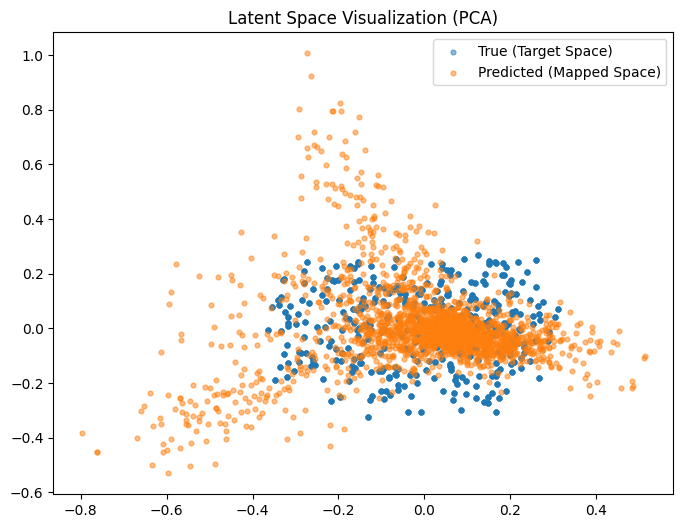

TypeError: TSNE.__init__() got an unexpected keyword argument 'n_iter'

In [ ]:
from challenge.src.eval import visualize_retrieval
import numpy as np
import torch

visualize_latent_space(model, X_val, y_val, DEVICE, method="pca")
visualize_tsne(model, X_val, y_val, DEVICE, n_samples=2000)


visualize_latent_space_3d(model, X_val, y_val, DEVICE, n_samples=2000, method="pca")
visualize_latent_space_3d(model, X_val, y_val, DEVICE, n_samples=1000, method="tsne")

val_caption_text = train_data['captions/text'][~TRAIN_SPLIT]
val_text_embd = X_val
img_VAL_SPLIT = label[~TRAIN_SPLIT].sum(dim=0) > 0
val_img_file = train_data['images/names'][img_VAL_SPLIT]
val_img_embd = torch.from_numpy(train_data['images/embeddings'][img_VAL_SPLIT])
val_label = np.nonzero(train_data['captions/label'][~TRAIN_SPLIT][:,img_VAL_SPLIT])[1]

# Sample and visualize
for i in range(5):
    idx = np.random.randint(0, 100)
    caption_embd = val_text_embd[idx]
    caption_text = val_caption_text[idx]
    gt_index = val_label[idx]

    with torch.no_grad():
        pred_embds = model(caption_embd.to(DEVICE)).cpu()

        visualize_retrieval(
            pred_embds,
            gt_index,
            val_img_file,
            caption_text, val_img_embd, k=5)

## Submission

In [ ]:
test_data = load_data("data/test/test.clean.npz")

test_embds = test_data['captions/embeddings']
test_embds = torch.from_numpy(test_embds).float()

with torch.no_grad():
    pred_embds = model(test_embds.to(DEVICE)).cpu()

submission = generate_submission(test_data['captions/ids'], pred_embds, 'submission.csv')
print(f"Model saved to: {MODEL_PATH}")

Generating submission file...
✓ Saved submission to submission.csv
Model saved to: models/mlp_baseline.pth


In [ ]:
# --- Evaluate retrieval performance ---
from challenge.src.eval import evaluate_retrieval  # adattalo al tuo path
import numpy as np

model.eval()
with torch.no_grad():
    z_pred_val = model(X_val.to(DEVICE)).cpu()

# ground truth embeddings (target images)
z_img_val = y_val.cpu()
gt_indices = np.arange(len(z_img_val))  # ogni caption ha la sua immagine target

results = evaluate_retrieval(
    translated_embd=z_pred_val,
    image_embd=z_img_val,
    gt_indices=gt_indices,
    max_indices=50,
    batch_size=128
)

print("\n=== Retrieval evaluation (validation set) ===")
for k, v in results.items():
    print(f"{k:>12}: {v:.4f}")



=== Retrieval evaluation (validation set) ===
         mrr: 0.4030
        ndcg: 0.5430
 recall_at_1: 0.1720
 recall_at_3: 0.5063
 recall_at_5: 0.8386
recall_at_10: 0.9386
recall_at_50: 0.9959
     l2_dist: 0.9009
